In [1]:
import pandas as pd
import os

%matplotlib inline

In [2]:
NOTEBOOK_DIR = os.getcwd()
BASE_DIR = os.path.dirname(NOTEBOOK_DIR)
DATA_DIR = os.path.join(BASE_DIR, "data/")

ORDERS = os.path.join(DATA_DIR, "orders.csv")
REVIEWS = os.path.join(DATA_DIR, "reviews.csv")
SIZE_MAPPINGS = os.path.join(DATA_DIR, "size_mapping.csv")
STYLE_ATTR = os.path.join(DATA_DIR, "style_attributes.csv")
USER_ATTR = os.path.join(DATA_DIR, "user_attributes.csv")

DATE_FRMT = "%Y-%m-%d"

In [3]:
def to_dates(df, cols):
    _df = df.copy()
    for col in cols:
        _df[col] = pd.to_datetime(df[col], format=DATE_FRMT)
    return _df

# Orders

 - 1231230 total records, only 1228395 are unique order_ids (~3000 duplicates)
 - 35000 unique user_ids (top has ~ 300 orders)
 - ordered_date between 2017-01-01 and 2018-03-31
 - rental begins between 2017-01-04 and 2018-07-14 (about 1.5 years of data)
 - 4000 unique styles, top 1551
 - 24167 unique skus top 556
 - no missing values
 
 # Questions
 - Why duplicate order_ids?  Are they full-row duplicates (Yes)
 - distribution of user order frequency, how many repeat interactions
 - Last date for ordered_date id 2018-03-31, last date for rental begins is 2018-07-14 (does this imply 3.5 month lag?)
 - does days_rented correlate to satisfaction / fit


In [41]:
orders = pd.read_csv(ORDERS)
orders = to_dates(orders, ['ordered_date', 'rental_begin_date'])
orders.describe(include='all')


,order_id,user_id,ordered_date,rental_begin_date,style,sku,days_rented
count,1231230,1231230,1231230,1231230,1231230,1231230,1.231230e+06
unique,1228395,35000,433,378,4000,24167,NaN
top,5033225d-10c9-37be-b395-eaf02217cadd,a44957e3-180b-3fe0-a2e6-ef83b2cc17c5,2017-10-17 00:00:00,2017-12-20 00:00:00,SAL28,KS95_ONESIZE,NaN
freq,4,307,9471,12311,1551,556,NaN
first,NaN,NaN,2017-01-01 00:00:00,2017-01-04 00:00:00,NaN,NaN,NaN
last,NaN,NaN,2018-03-31 00:00:00,2018-07-14 00:00:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,1.241669e+01
std,NaN,NaN,NaN,NaN,NaN,NaN,2.997008e+01
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,4.000000e+00


In [42]:
orders.drop_duplicates(inplace=True)

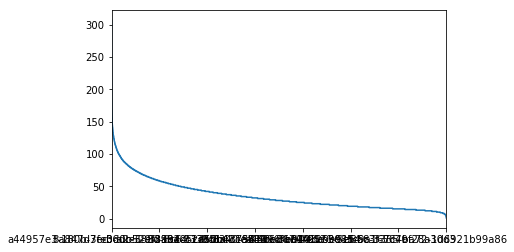

In [43]:
orders['user_id'].value_counts().plot()


In [44]:
orders = orders.set_index("ordered_date").sort_index()
orders['order_cnt'] = 1
orders['cust_cnt'] = ~orders['user_id'].duplicated()
orders['order_cum'] = orders['order_cnt'].cumsum()
orders['cust_cum'] = orders['cust_cnt'].cumsum()

/Users/r632293/.conda/envs/rtr/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.
/Users/r632293/.conda/envs/rtr/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  


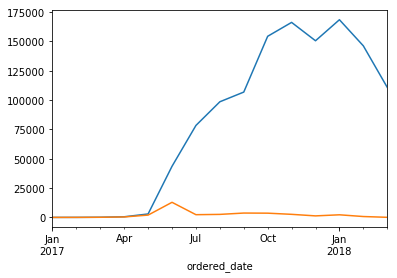

In [46]:
orders.order_cnt.resample('M', convention='start', how='sum').plot()
orders.cust_cnt.resample('M', convention='start', how='sum').plot()

/Users/r632293/.conda/envs/rtr/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).max()
  """Entry point for launching an IPython kernel.
/Users/r632293/.conda/envs/rtr/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).max()
  


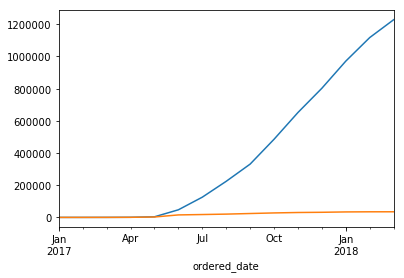

In [47]:
orders.order_cum.resample('M', convention='start', how='max').plot()
orders.cust_cum.resample('M', convention='start', how='max').plot()

ordered_date
2017-01-01        1
2017-01-02        2
2017-01-02        3
2017-01-03        4
2017-01-03        5
2017-01-07        6
2017-01-07        7
2017-01-11        8
2017-01-16        9
2017-01-16       10
2017-01-18       11
2017-01-18       12
2017-01-18       13
2017-01-18       14
2017-01-18       14
2017-01-20       15
2017-01-20       16
2017-01-22       17
2017-01-22       18
2017-01-22       18
2017-01-23       19
2017-01-23       20
2017-01-25       21
2017-01-25       22
2017-01-25       23
2017-01-27       24
2017-01-28       25
2017-01-30       26
2017-01-31       27
2017-02-01       27
              ...  
2018-03-31    35000
2018-03-31    35000
2018-03-31    35000
2018-03-31    35000
2018-03-31    35000
2018-03-31    35000
2018-03-31    35000
2018-03-31    35000
2018-03-31    35000
2018-03-31    35000
2018-03-31    35000
2018-03-31    35000
2018-03-31    35000
2018-03-31    35000
2018-03-31    35000
2018-03-31    35000
2018-03-31    35000
2018-03-31    35000
2018-03